In [1]:
import pandas as pd
import numpy as np
import pickle 
import torch
from data.prepareData import prepareDataLoader_fromPkl
import matplotlib.pyplot as plt
from scripts.visualisation import plot_cpg_reconstruction, plot_activations_latSpace
import seaborn as sns
from tensorflow.python.summary.summary_iterator import summary_iterator

# AE stability?

Train same AE 4 times and check final loss value etc. --> is it stable?

In [5]:
# ################################ Force longer learning ################################
# !python train_AE.py --name stability/latSize_25_v4 \
#                     --train_file chr22_overlap_train_methyl_array.pkl \
#                     --val_file chr22_overlap_val_methyl_array.pkl \
#                     --hidden_layer_encoder_topology 2000 500 \
#                     --latentSize 25 \
#                     --learning_rate 1e-04 \
#                     --n_epochs 500 \
#                     --patienceEarlyStopping 300


normalAE(
  (encoder): Sequential(
    (0): Linear(in_features=4671, out_features=2000, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): PReLU(num_parameters=1)
    (3): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=2000, out_features=500, bias=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): PReLU(num_parameters=1)
    (7): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Linear(in_features=500, out_features=25, bias=True)
    (9): PReLU(num_parameters=1)
  )
  (decoder): Sequential(
    (0): Linear(in_features=25, out_features=500, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=500, out_features=2000, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=2000, out_features=4671, bias=True)
    (5): Sigmoid()
  )
)
		Logging to logs/stability/latSize_25_v4/checkpoint
cpu
Epoch: 1
Training Loss: 320833.346
Validation Loss: 26

# Analyse

In [6]:
PATH_data = "data"
PATH_results = "logs"

with open(os.path.join(PATH_data, "chr22_overlap_test_methyl_array.pkl"), "rb") as f: test_dataset = pickle.load(f) #
test_tensor = torch.tensor(test_dataset["beta"].values, dtype=torch.float32)

In [7]:
def getValLoss(name):
    for file in os.listdir(f"logs/{name}"):
        if file.startswith("events"):
            val_loss = []
            for summary in summary_iterator(f"logs/{name}/{file}"):
                if summary.summary.value:
                    if summary.summary.value[0].tag == "Val - Loss":
                        val_loss.append(summary.summary.value[0].simple_value)
    return val_loss[-20:]


def getPearsonR(orig, recon):
    from scipy.stats import pearsonr
    pearson = []
    for i in range(recon.shape[1]):
        pearson.append(pearsonr(orig.detach().numpy()[:,i], recon[:,i])[0])
    return pearson


def getRegression(name, latSpace, test_data):
    regrPath = f"logs/{name}/regression"
    regr_model = pickle.load(open(f"{regrPath}/RFregressor.sav", 'rb'))

    # Impute missing values target values with mean (quick & dirty)
    y_test_filled = test_data["pheno"]["Age"].fillna(value=test_data["pheno"]["Age"].mean())

    y_pred = regr_model.predict(latSpace)
    r2 = regr_model.score(latSpace, y_test_filled)
    print(r2)
    return r2 #y_pred
    

In [8]:
names = ["stability/latSize_25_v1", "stability/latSize_25_v2", "stability/latSize_25_v3", "stability/latSize_25_v4"]
names_short = [ele.split("/")[1] for ele in names]

df_loss = pd.DataFrame()
df_pearson = pd.DataFrame()
lst_r2 = []
for name in names:
    model = torch.load(f"logs/{name}/checkpoint/trainedModel.pth", map_location=torch.device('cpu'))

    # Get recon and latent space (from test data)
    with torch.no_grad():
        recon = model(test_tensor).detach().numpy()
        latSpace = model.generate_embedding(test_tensor)

    # Get Loss
    df_loss[name] = getValLoss(name)
    # Get Pearson
    df_pearson[name] = getPearsonR(orig=test_tensor, recon=recon)
    # Get supervised prediction (regression)
    lst_r2.append(getRegression(name, latSpace, test_dataset))

df_r2 = pd.DataFrame(lst_r2, index=names).T

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
0.7406792361762449
0.7372382314895765
0.7601289484640144
0.722544270665318


Text(0, 0.5, 'Prediction of Age - R2 score')

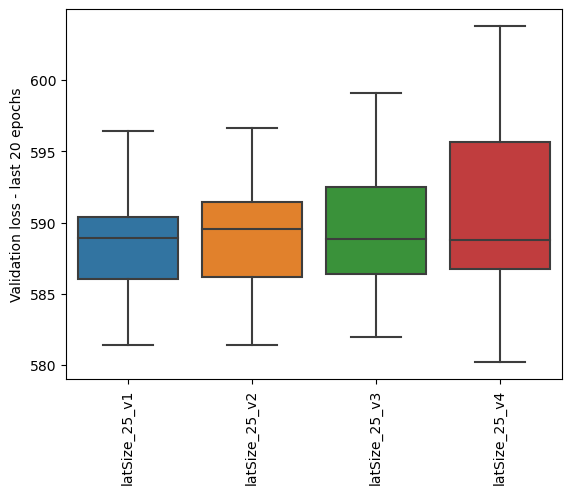

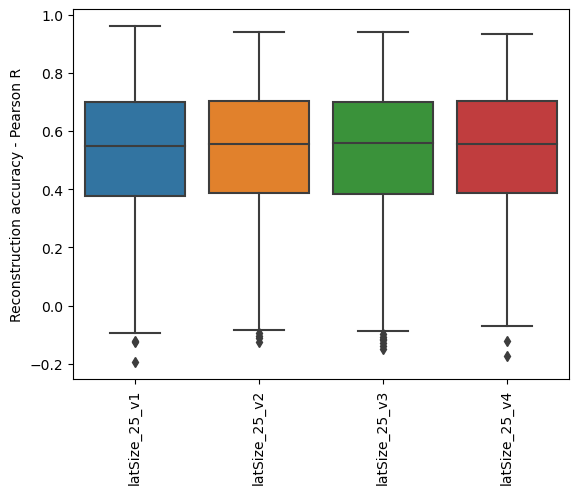

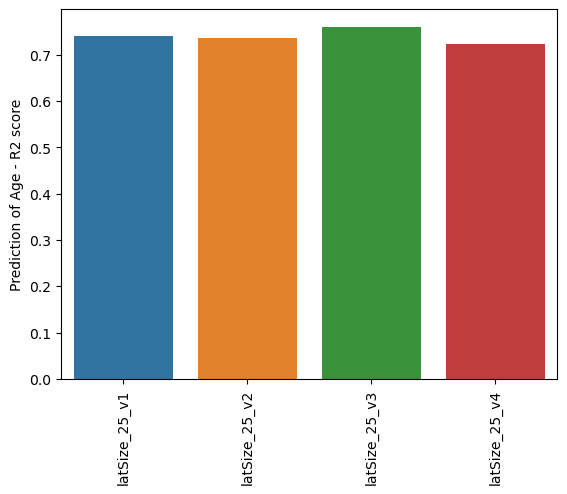

In [9]:
fig, ax = plt.subplots()
sns.boxplot(data=df_loss, ax=ax)
ax.set_xticklabels(names_short, rotation=90)
ax.set_ylabel("Validation loss - last 20 epochs")

fig, ax = plt.subplots()
sns.boxplot(data=df_pearson)
ax.set_xticklabels(names_short, rotation=90)
ax.set_ylabel("Reconstruction accuracy - Pearson R")

fig, ax = plt.subplots()
sns.barplot(data=df_r2, ax=ax)
ax.set_xticklabels(names_short, rotation=90)
ax.set_ylabel("Prediction of Age - R2 score")

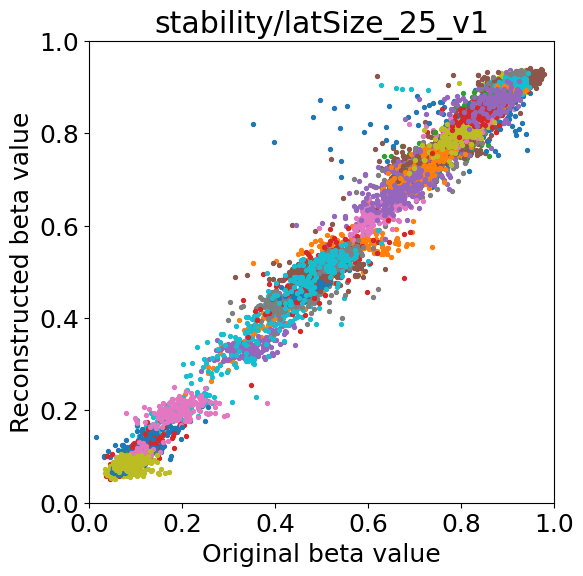

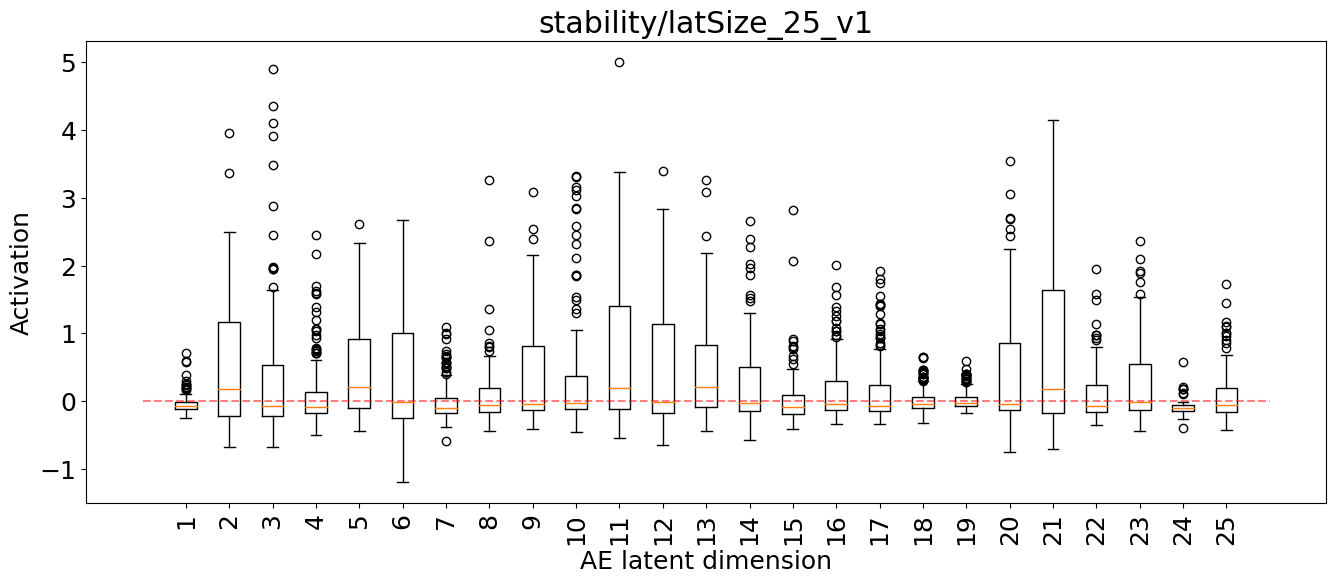

In [11]:
name2 = "stability/latSize_25_v1"
model2 = torch.load(f"logs/{name2}/checkpoint/trainedModel.pth", map_location=torch.device('cpu'))

plot_cpg_reconstruction(model2, test_tensor, title=name2)
plot_activations_latSpace(model2, test_tensor, title=name2)